In [26]:
import math
def entropy(waveform):
    dist = PMF(waveform)
    ent = 0
    for prob in dist:
        # print("PROB:", prob)
        if prob != 0:
            info = math.log(prob, 2)
        else:
            info = 0
        # print("INFO:", info)
        ent += - prob * info
    return ent


def PMF(waveform):
    hist = histogram(waveform)
    return [count / sum(hist) for count in hist]


def histogram(waveform):
    heights = sorted([abs(pt) for pt in waveform])
    n = len(heights)
    (Q1, Q2, Q3) = quartiles(heights)
    IQR = Q3 - Q1
    data_range = heights[-1] - heights[0]
    bin_width = 2 * IQR / (n ** (1 / 3))
    num_bins = math.ceil(data_range / bin_width)
    bins = []
    # Loop through each bin in the histogram
    for i in range(num_bins):
        bins.append(0)
        # Loop through each data point to see if it should be added to the bin
        for h in heights:
            # Most bins are inclusive only at lower bound: [x0, x1)
            if bin_width * i <= h < bin_width * (i + 1):
                bins[-1] += 1
            # Last bin is inclusive at both bounds: [x1, x2]
            elif i == num_bins - 1 and h == bin_width * (i + 1):
                bins[-1] += 1
    return bins


def quartiles(data):
    d = sorted(data)
    L = len(d)
    if L % 4 == 0:
        Q1 = ind2(d, L // 4)
        Q2 = ind2(d, L // 2)
        Q3 = ind2(d, (L // 4) * 3)
    elif L % 4 == 1:
        Q1 = ind2(d, L // 4)
        Q2 = d[L // 2]
        Q3 = ind2(d, (L // 4) * 3 + 1)
    elif L % 4 == 2:
        Q1 = d[L // 4]
        Q2 = ind2(d, L // 2)
        Q3 = d[(L // 4) * 3 + 1]
    elif L % 4 == 3:
        Q1 = d[L // 4]
        Q2 = d[L // 2]
        Q3 = d[(L // 4) * 3 + 2]
    return Q1, Q2, Q3


# averages two elements from a list with indices of index2 and index2-1 (for taking medians when # of elements is even)
def ind2(lis, index2):
    return (lis[index2 - 1] + lis[index2]) / 2


def kurtosis(data):
    mu = avg(data)
    D = [point - mu for point in data]

    numerator = avg([d ** 4 for d in D])
    denominator = avg([d ** 2 for d in D]) ** 2
    return numerator / denominator


def avg(l):
    return sum(l) / len(l)


def outlier(data):
    Q1, _, Q3 = quartiles(data)
    threshold = Q3 + (Q3 - Q1)
    return [pt > threshold for pt in data]

In [27]:
import os
import matplotlib.pyplot as plt
import scipy.signal as sig
import numpy as np


class Dataset:
    def __init__(self):
        self.hits = []
    def add_hit(self, fname):
        hit = Hit()
        hit.read_file(fname)
        self.hits.append(hit)
        return self.hits[-1]
    def add_hits(self, folder):
        for file in os.listdir(folder):
            f = os.path.join(folder, file)
            self.add_hit(f)
            if len(self.hits) % 100 == 0:
                print(len(self.hits))

class Hit:
    "represents a waveform with a fixed number of voltage values over time"
    def __init__(self, fname=None, waveform=None):
        self.file_name = fname
        self.start_time = None
        self.waveform = waveform
        self.entropy = None
        self.ie_outlier = None
        self.sample_interval = None
        self.spectrogram = None


    def read_file(self, fname=None):
        if fname is not None:
            self.file_name = fname
        with open(self.file_name, mode='r') as f:
            txt = f.readlines()
        for ind, line in enumerate(txt):
            if "TIME OF TEST:" in line:
                self.start_time = float(line.split(": ")[1])
            if "SAMPLE INTERVAL (Seconds):" in line:
                self.sample_interval = float(line.split(": ")[1])
            if line=="\n":
                self.waveform = []
                break
        else:
            print(fname)
            raise ValueError("Expected blank line not found in waveform datafile")
        for line in txt[ind+1:]:
            self.waveform.append(float(line))
    def spect(self, binsize, sample_rate=1, plot=False):
        pass

def spect(wave, binsize, sample_rate=1, plot=False):
    '''if plot:
        ext = (time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1])
        stretch = (time_axis[-1]-time_axis[0]) / (freq_axis[-1]-freq_axis[0])
        plt.imshow(intensity, extent=ext, aspect=0.8*stretch, origin="lower")
        plt.show()'''
    return sig.spectrogram(np.array(wave), nperseg=binsize, fs=sample_rate)[2]

In [28]:
import tensorflow as tf
from statistics import stdev
import time
from tensorflow.keras import layers, models




In [29]:
print("starting")
folder = "Waveform2"
test = Dataset()
t1 = time.time()
test.add_hits(f"Waveform4")
t2 = time.time()
print("imported", t2-t1)

starting
100
200
300
400


KeyboardInterrupt: 

In [ ]:
for h in test.hits:
    h.spectrogram = spect(h.waveform, 120, sample_rate=1)
    #h.entropy = entropy(h.waveform)
t3 = time.time()
print("spectrogrammed", t3-t2)


spectrogrammed 81.30070567131042


In [ ]:

for h in test.hits:
    f = "SG\\" + h.file_name.split("\\")[-1].split(".")[0]
    f2 = "waves\\" + h.file_name.split("\\")[-1].split(".")[0]

    np.save(f,h.spectrogram)
    np.save(f2,h.waveform)
        

In [ ]:
w0 = np.array([h.spectrogram for h in test.hits])
w1 = np.sqrt(w0)
std = np.std(w1.flatten())
mean = np.mean(w1)
w = (w1- mean) / (10*std)
ie = np.array([h.entropy for h in test.hits])
y = np.array([np.array(o+1) for o in outlier(ie)])

print("done")

done


In [36]:
import os
import numpy as np
specs = []
for file in os.listdir("SG")[0:-1:25]:
    specs.append(np.load("SG\\"+file))

print(len(specs))

2893


In [37]:
np.average(specs)
np.std(specs)
np.max(specs)


160.76249236090555

In [41]:

np.random.seed(42)
filt = np.random.rand(len(specs))
sp_train = []; sp_val = []
for i in range(len(specs)):
    if filt[i]<0.8:
        sp_train.append(specs[i])
    else:
        sp_val.append(specs[i])

sp_train = np.array(sp_train)
sp_val = np.array(sp_val)

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Autoencoder(models.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoded = None
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(61, 58, 1)),
        layers.Conv2D(16, 3, activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        #layers.Flatten(),
        #layers.Dense(200)])
    ])
    self.decoder = tf.keras.Sequential([
      #layers.Input(shape=(200)),
      #layers.Dense(49248, activation='sigmoid'),
      #layers.Reshape((57, 54, 16)),
      layers.Input(shape=(57, 54, 16)),
      layers.Conv2DTranspose(16, 3, activation='relu'),
      layers.Conv2DTranspose(16, 3, activation='relu'), 
      layers.Conv2DTranspose(8, 3, activation='relu'),
      layers.Conv2D(1, 3, activation='sigmoid')
      ])

  def call(self, x):
    self.encoded = self.encoder(x)
    
    decoded = self.decoder(self.encoded)
    return decoded

automod = Autoencoder()
automod.encoder.summary()
automod.decoder.summary()
automod.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


autohist = automod.fit(x=sp_train, y=sp_train, epochs=50, validation_data=(sp_val, sp_val))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 59, 56, 16)        160       
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 54, 16)        2320      
                                                                 
Total params: 2,480
Trainable params: 2,480
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_9 (Conv2DT  (None, 59, 56, 16)       2320      
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 61, 58, 16)       2320      
 Transpose)                   

In [ ]:
print(test.hits[105].start_time)
print(w[10][30])

480.8482005
[-0.01103973 -0.01117128 -0.01114536 -0.01120104 -0.01108548 -0.01107115
 -0.01118689 -0.01098129 -0.01109879 -0.0110312  -0.01106755 -0.01117576
 -0.01080272 -0.01114507 -0.01111446 -0.01110455 -0.01116207 -0.0110984
 -0.01120968 -0.01110553 -0.01112468 -0.01110739 -0.01111402 -0.01113548
 -0.01114069 -0.01092785 -0.01105954 -0.01112125 -0.01091261 -0.01117919
 -0.01105419 -0.01105855 -0.01116654 -0.0110994  -0.01110171 -0.01085464
 -0.0110514  -0.01111004 -0.01120572 -0.01117078 -0.01112172 -0.01082401
 -0.01128724 -0.01128724 -0.01128724 -0.01128724 -0.01128724 -0.01128724
 -0.01128724 -0.01128724 -0.01128724 -0.01128724 -0.01128724 -0.01128724
 -0.01128724 -0.01128724 -0.01128724 -0.01128724]


1.0210592036251647
0.00401419
0.0
0.0
0.000368987826562935 0.0040088287 0.0 0.0
0.0009031148894091567 0.0040088305 0.0 0.0
0.0021801511834751044 0.0040088287 0.0 0.0
0.001356925629985796 0.0040088287 0.0 0.0
0.0018016546682912621 0.0040088287 0.0 0.0
0.0015808761521756986 0.0040088287 0.0 0.0


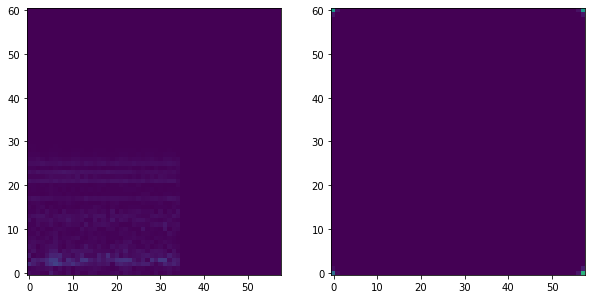

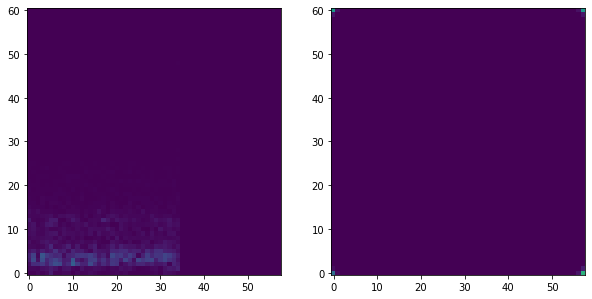

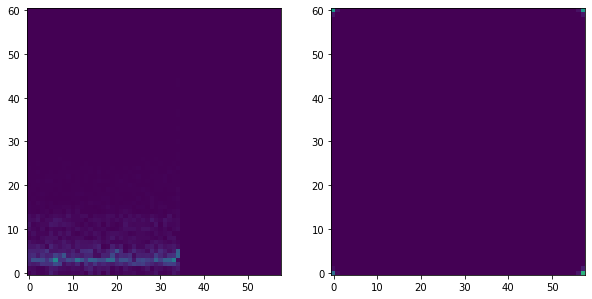

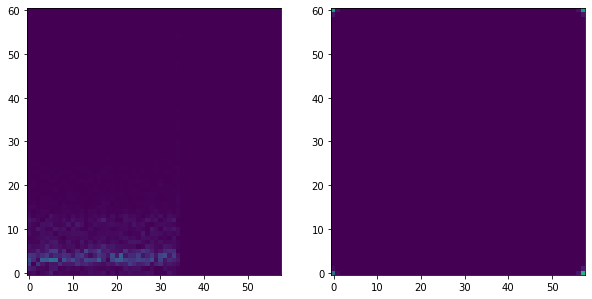

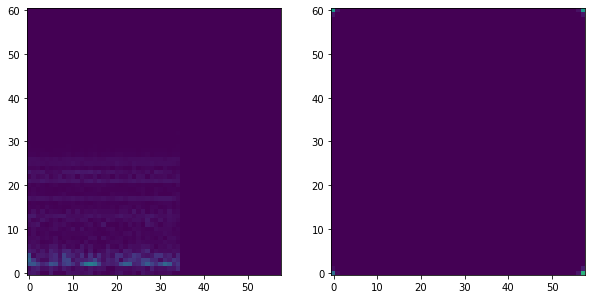

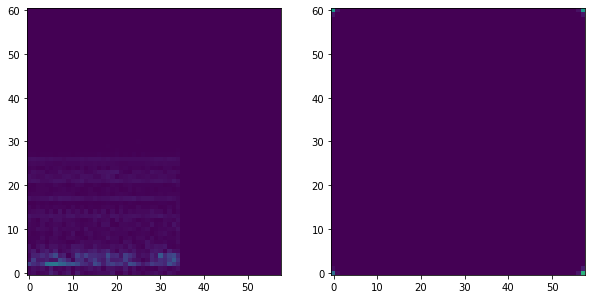

In [46]:
encoded = automod.encoder(sp_val).numpy()
decoded = automod.decoder(encoded).numpy()
decoded = decoded[:,:,:,0]

wmax = max(max(max(row) for row in pic) for pic in sp_val)
wmin = min(min(min(row) for row in pic) for pic in sp_val)
print(max(max(max(row) for row in pic) for pic in sp_val))
print(max(max(max(row) for row in pic) for pic in decoded))
print(min(min(min(row) for row in pic) for pic in sp_val))
print(min(min(min(row) for row in pic) for pic in decoded))
for i in range(5, 506, 100):
    print(max(max(row) for row in sp_val[i]), max(max(row) for row in decoded[i]), min(min(row) for row in sp_val[i]), min(min(row) for row in decoded[i]))
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(np.sqrt(np.maximum(sp_val[i], 0)), origin="lower", vmin=0, vmax=0.05)
    ax[1].imshow(np.sqrt(decoded[i]), origin="lower", vmin=0, vmax=0.05)
plt.show()
#plt.plot(autohist.history['loss'], label='loss')
#plt.plot(autohist.history['val_loss'], label = 'val_loss')
#plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 59, 56, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 26, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 3872)             

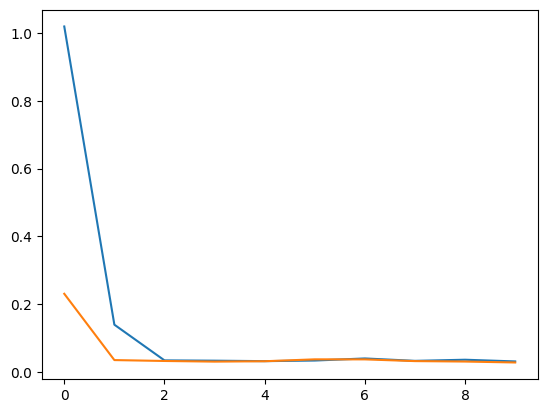

In [ ]:



model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(61, 58, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(30))


model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x=w, y=y, epochs=10, validation_data=(w, y))



plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.show()